# Multi-agent RAG System 🤖🤝🤖

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

🚨 **NOTE**: This tutorial is advanced. You should have a solid understanding of the concepts discussed in the following cookbooks before diving in:
- [Agents Cookbook](agents)
- [Advanced RAG Cookbook](advanced_rag)

In this notebook, we will create a **multi-agent RAG system**, a system where multiple agents work together to retrieve and generate information, combining the strengths of **retrieval-based systems** and **generative models**.

## What is a Multi-agent RAG System? 🤔

A **Multi-agent Retrieval-Augmented Generation (RAG)** system consists of multiple agents that collaborate to perform complex tasks. The retrieval agent retrieves relevant documents or information, while the generative agent synthesizes that information to generate meaningful outputs. There is a Manager Agent that orchestrates the system and selects the most appropriate agent for the task based on the user input.

The original idea for this recipe comes from [this post](https://weaviate.io/blog/what-is-agentic-rag). You may find more details about it there.

Below, you can find the architecture that we will build.


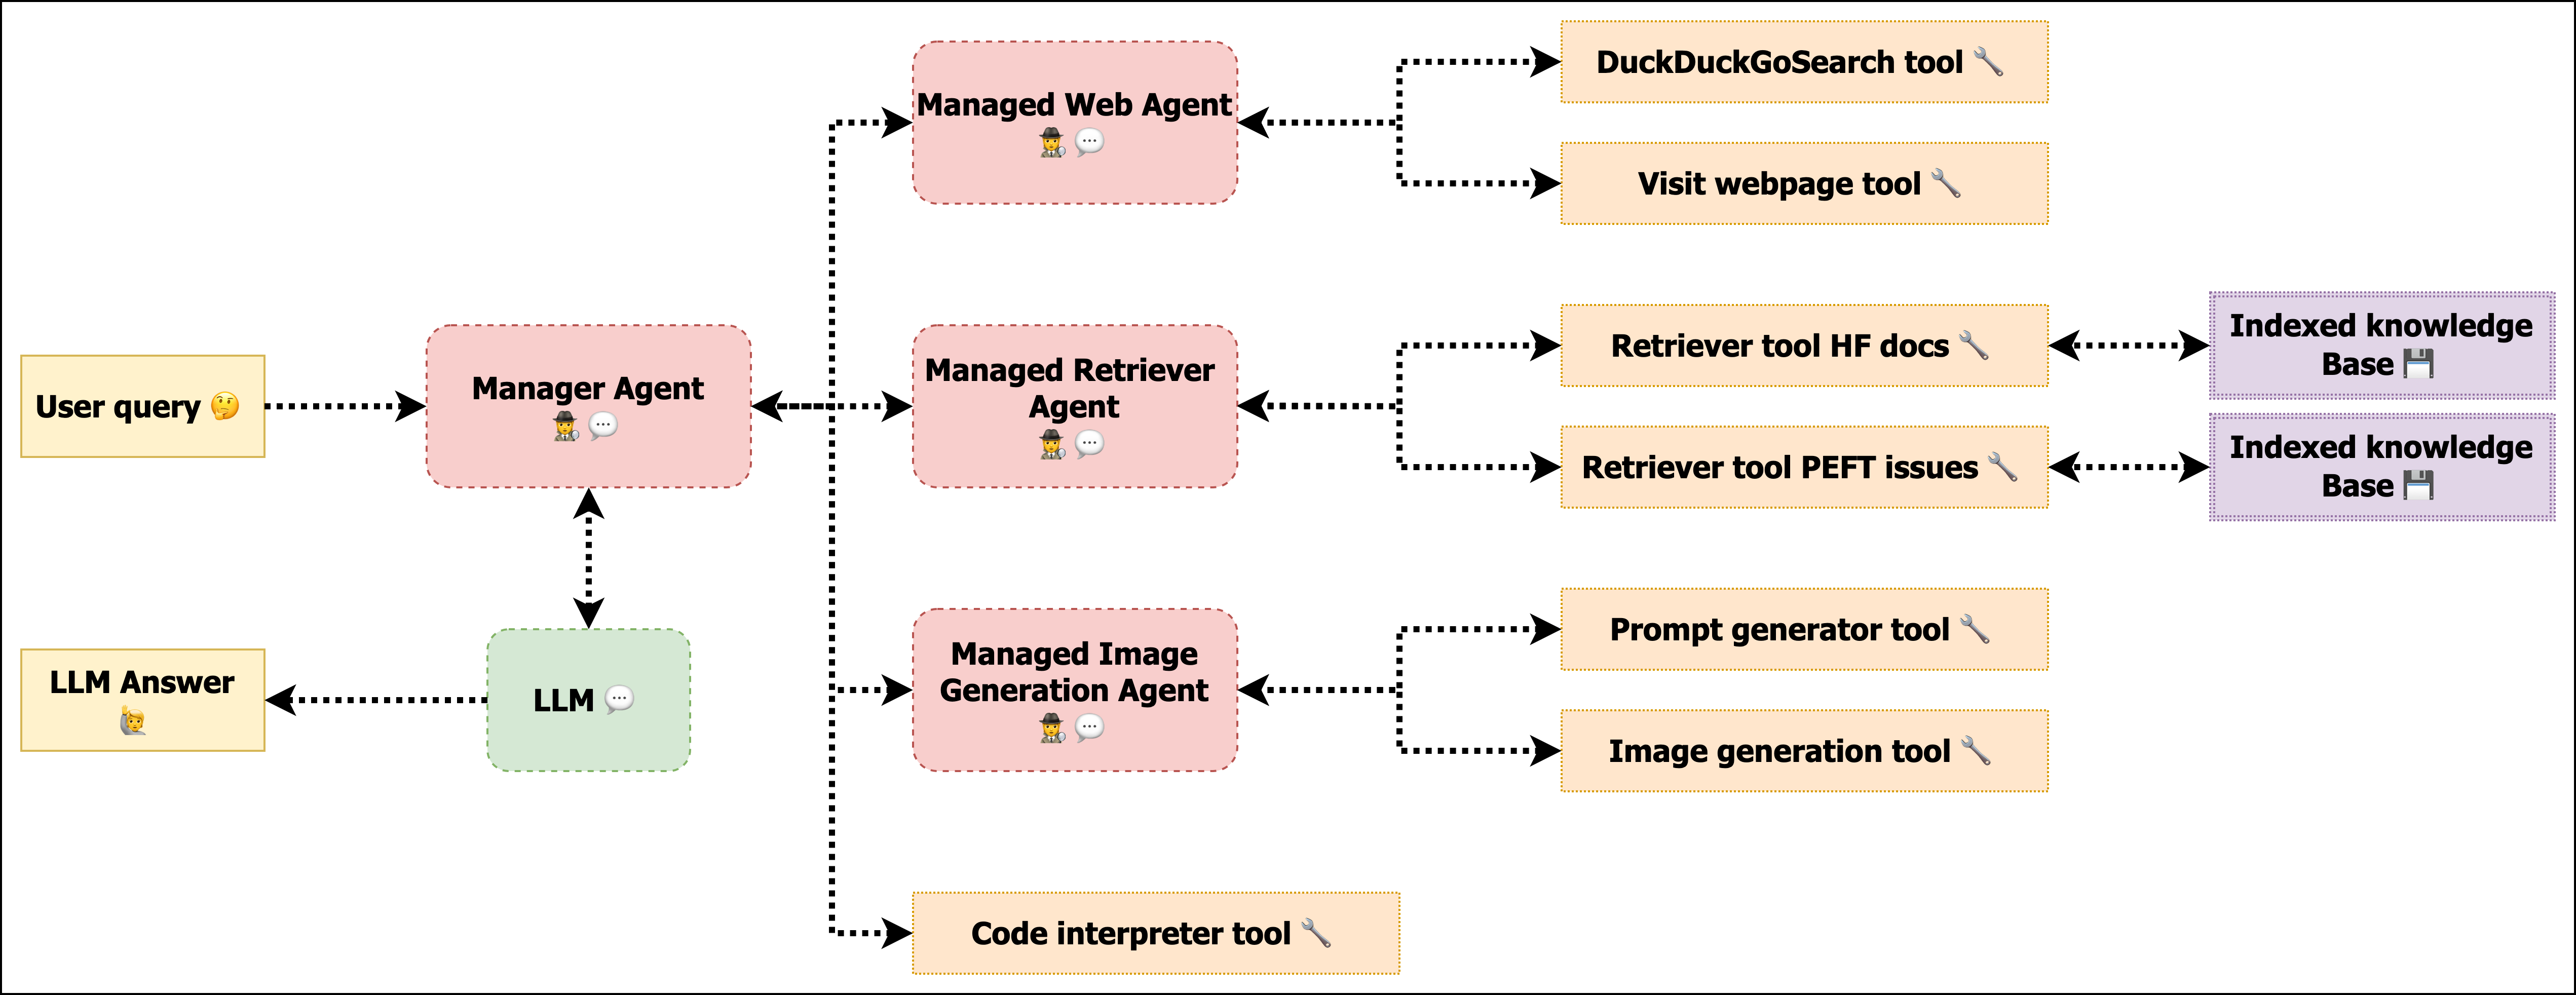

## 1. Install dependencies

First, let's install the dependencies:

In [ ]:
!pip install -q smolagents

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!pip install markdownify duckduckgo-search spaces gradio-tools langchain langchain-community langchain-huggingface faiss-cpu --upgrade -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Let's login in order to call the HF Inference API:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# 2. Let's create our multi-agent RAG system

In this section, we will create each of the agents present in our RAG system.

We will have 3 agents managed by a central one (refer to the image for details):

* **🕵💬 Web search agent**: It will include the [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) tool and the [`VisitWebpageTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py). As you can see, each agent may contain a list of tools.
* **🕵💬 Retriever agent**: It will include two tools for retrieving information from two different knowledge bases.
* **🕵💬 Image generation agent**: It will include a prompt generator tool in addition to the image generation tool.

💡 In addition to these agents, the **central/orchestrator agent** will also have access to the **code interpreter tool** to execute code.

We will use [Qwen/Qwen2.5-72B-Instruct](https://huggingface.co/Qwen/Qwen2.5-72B-Instruct) as the LLM for each component, which will be accessed via the Inference API. Depending on the agent, a different LLM model may be used.

> _Note:_ The Inference API hosts models based on various criteria, and deployed models may be updated or replaced without prior notice. Learn more about it [here](https://huggingface.co/docs/api-inference/supported-models).



In [ ]:
from smolagents import HfApiModel

model_id = "Qwen/Qwen2.5-72B-Instruct"
model = HfApiModel(model_id)

Let's dive into the details of each agent!

### 2.1 Web search agent 🔍

The **Web search agent** will utilize the [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) to search the web and gather relevant information. This tool acts as a search engine, querying for results based on the specified keywords.

To make the search results actionable, we also need the agent to access the web pages retrieved by DuckDuckGo. That can be achieved by using the built-in [`VisitWebpageTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py).

Let’s explore how to set it up and integrate it into our system!

The following code comes from the original [Have several agents collaborate in a multi-agent hierarchy 🤖🤝🤖](https://huggingface.co/learn/cookbook/multiagent_web_assistant) recipe, so refer to it for more details.





#### 2.1.1 Build our multi-tool web agent 🤖

Now that we've set up the basic search and webpage tools, let's build our **multi-tool web agent**. This agent will combine several tools to perform more complex tasks, leveraging the capabilities of the `ToolCallingAgent`.

The `ToolCallingAgent` is particularly well-suited for web search tasks because its JSON action formulation requires only simple arguments and works seamlessly in sequential chains of single actions. This makes it an excellent choice for scenarios where we need to search the web for relevant information and retrieve detailed content from specific web pages. In contrast, `CodeAgent` action formulation is better suited for scenarios involving numerous or parallel tool calls.

By integrating multiple tools, we can ensure that our agent interacts with the web in a sophisticated and efficient manner.

Let's dive into how to set this up and integrate it into our system!



In [ ]:
from smolagents import CodeAgent, ToolCallingAgent, ManagedAgent, DuckDuckGoSearchTool, VisitWebpageTool

web_agent = ToolCallingAgent(
    tools=[DuckDuckGoSearchTool(), VisitWebpageTool()],
    model=model
)

Now that we have our first agent, let's wrap it as a `ManagedAgent` so the central agent can use it.

In [ ]:
managed_web_agent = ManagedAgent(
    agent=web_agent,
    name="search_agent",
    description="Runs web searches for you. Give it your query as an argument.",
)

### 2.2 Retriever agent 🤖🔍

The second agent in our multi-agent system is the **Retriever agent**. This agent is responsible for gathering relevant information from different sources. To achieve this, it will utilize two tools that retrieve data from two separate knowledge bases.

We will reuse two data sources that were previously used in other RAG recipes, which will allow the retriever to efficiently gather information for further processing.

By leveraging these tools, the Retriever agent can access diverse datasets, ensuring a comprehensive collection of relevant information before passing it on to the next step in the system.

Let's explore how to set up the retriever and integrate it into our multi-agent system!


#### 2.2.1 HF docs retriever tool 📚

The first retriever tool comes from the [Agentic RAG: turbocharge your RAG with query reformulation and self-query! 🚀](https://huggingface.co/learn/cookbook/agent_rag) recipe.

For this retriever, we will use a dataset that contains a compilation of documentation pages for various `huggingface` packages, all stored as markdown files. This dataset serves as the knowledge base for the retriever agent to search and retrieve relevant documentation.

To make this dataset easily accessible for our agent, we will:

1. **Download the dataset**: We will first fetch the markdown documentation.
2. **Embed the data**: We will then convert the documentation into embeddings using a **FAISS vector store** for efficient similarity search.

By doing this, the retriever tool can quickly access the relevant pieces of documentation based on the search query, enabling the agent to provide accurate and detailed information.

Let’s go ahead and set up the tool to handle the documentation retrieval!



In [ ]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    AutoTokenizer.from_pretrained("thenlper/gte-small"),
    chunk_size=200,
    chunk_overlap=20,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

# Split docs and keep only unique ones
print("Splitting documents...")
docs_processed = []
unique_texts = {}
for doc in tqdm(source_docs):
    new_docs = text_splitter.split_documents([doc])
    for new_doc in new_docs:
        if new_doc.page_content not in unique_texts:
            unique_texts[new_doc.page_content] = True
            docs_processed.append(new_doc)

print("Embedding documents...")
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
huggingface_doc_vector_db = FAISS.from_documents(
    documents=docs_processed,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
)

Now that we have the documentation embedded in FAISS, let's create the **RetrieverTool**. This tool will query the FAISS vector store to retrieve the most relevant documents based on the user’s query.

This will allow the retriever agent to access and provide relevant documentation when queried.



In [ ]:
from smolagents import Tool
from langchain_core.vectorstores import VectorStore

class RetrieverTool(Tool):
    name = "retriever"
    description = "Using semantic similarity, retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        }
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.vectordb.similarity_search(
            query,
            k=7,
        )

        return "\nRetrieved documents:\n" + "".join(
            [
                f"===== Document {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

In [ ]:
huggingface_doc_retriever_tool = RetrieverTool(huggingface_doc_vector_db)

#### 2.2.2 PEFT issues retriever tool

For the second retriever, we will use the [PEFT issues](https://github.com/huggingface/peft/issues) as data source as in the [Simple RAG for GitHub issues using Hugging Face Zephyr and LangChain](https://huggingface.co/learn/cookbook/rag_zephyr_langchain).

Again, the following code comes from that recipe so refer to it for more details!

In [ ]:
from google.colab import userdata
GITHUB_ACCESS_TOKEN = userdata.get('GITHUB_PERSONAL_TOKEN')

In [ ]:
from langchain.document_loaders import GitHubIssuesLoader

loader = GitHubIssuesLoader(repo="huggingface/peft", access_token=GITHUB_ACCESS_TOKEN, include_prs=False, state="all")
docs = loader.load()

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
chunked_docs = splitter.split_documents(docs)

In [ ]:
peft_issues_vector_db = FAISS.from_documents(chunked_docs, embedding=embedding_model)

Let's now generate the second retriever tool using the same `RetrieverTool`.

In [ ]:
peft_issues_retriever_tool = RetrieverTool(peft_issues_vector_db)

#### 2.2.3 Build the Retriever agent

Now that we’ve created the two retriever tools, it’s time to build the **Retriever agent**. This agent will manage both tools and retrieve relevant information based on the user query.

We’ll use the `ManagedAgent` to integrate these tools and pass the agent to the central agent for coordination.


In [ ]:
retriever_agent = ToolCallingAgent(
    tools=[huggingface_doc_retriever_tool, peft_issues_retriever_tool], model=model, max_iterations=4, verbose=2
)

In [ ]:
managed_retriever_agent = ManagedAgent(
    agent=retriever_agent,
    name="retriever_agent",
    description="Retrieves documents from the knowledge base for you that are close to the input query. Give it your query as an argument. The knowledge base includes Hugging Face documentation and PEFT issues.",
)

### 2.3 Image generation agent 🎨

The third agent in our system is the **Image generation agent**. This agent will have two tools: one for refining the user query and another for generating the image based on the query. In this case, we will use the `CodeAgent` instead of a `ReactAgent` since the set of actions can be executed in one shot.

You can find more details about the image generation agent in the [Agents, supercharged - Multi-agents, External tools, and more](https://huggingface.co/docs/transformers/en/agents_advanced) documentation.

Let’s dive into how these tools will work together to generate images based on user input!




In [ ]:
from transformers import load_tool, CodeAgent

prompt_generator_tool = Tool.from_space("sergiopaniego/Promptist", name="generator_tool", description="Optimizes user input into model-preferred prompts")

In [ ]:
image_generation_tool = load_tool("m-ric/text-to-image", trust_remote_code=True)
image_generation_agent = CodeAgent(tools=[prompt_generator_tool, image_generation_tool], model=model)

🖼 Again, we use `ManagedAgent` to tell the central agent that it can manage it. Additionally, we’ve included an `additional_prompting` parameter to ensure the agent returns the generated image instead of just a text description.

In [ ]:
managed_image_generation_agent = ManagedAgent(
    agent=image_generation_agent,
    name="image_generation_agent",
    description="Generates images from text prompts. Give it your prompt as an argument.",
    additional_prompting="\n\nYour final answer MUST BE only the generated image location."
)

## 3. Let's add the general agent manager to orchestrate the system

The **central agent manager** will coordinate tasks between the agents. It will:

- **Receive user input** and decide which agent (Web search, Retriever, Image generation) handles it.
- **Delegate tasks** to the appropriate agent based on the user's query.
- **Collect and synthesize** results from the agents.
- **Return the final output** to the user.

We include all the agents we’ve developed as `managed_agents` and add any necessary imports for the code executor under `additional_authorized_imports`.

In [ ]:
manager_agent = CodeAgent(
    tools=[],
    model=model,
    managed_agents=[managed_web_agent, managed_retriever_agent, managed_image_generation_agent],
    additional_authorized_imports=["time", "datetime", "PIL"],
)

Now that everything is set up, let's test the performance of the multi-agent RAG system!

To do so, we'll provide some example queries and observe how the system delegates tasks between the agents, processes the information, and returns the final results.

This will help us understand the efficiency and effectiveness of our agents working together, and identify areas for optimization if necessary.

Let's go ahead and run some tests!

### 3.1 Example trying to trigger the search agent

In [ ]:
manager_agent.run("How many years ago was Stripe founded?")

======== New task ========
How many years ago was Stripe founded?
=== Agent thoughts:
Thought: To solve this problem, I need to find out the year Stripe was founded and then calculate the difference between the current year and the year of founding.
>>> Agent is executing the code below:
founding_year = search("When was Stripe founded?")
print(founding_year)
====
======== New task ========
You're a helpful agent named 'search'.
You have been submitted this task by your manager.
---
Task:
When was Stripe founded?
---
You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much information as possible so that they have a clear understanding of the answer.

Your final_answer WILL HAVE to contain these parts:
### 1. Task outcome (short version):
### 2. Task outcome (extremely detailed version):
### 3. Additional context (if relevant):

Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer w

14

### 3.2 Example trying to trigger the image generator agent

In [ ]:
result = manager_agent.run(
    "Improve this prompt, then generate an image of it.", prompt='A rabbit wearing a space suit'
)

======== New task ========
Improve this prompt, then generate an image of it.
You have been provided with these initial arguments: {'prompt': 'A rabbit wearing a space suit'}.
=== Agent thoughts:
Thought: I will first improve the prompt to make it more detailed and then use the `image_generation` tool to generate an image based on the improved prompt. I will store the improved prompt in a variable and print it for the next step.
>>> Agent is executing the code below:
improved_prompt = "A rabbit wearing a space suit, jumping in a zero-gravity environment, surrounded by stars and planets."
print(improved_prompt)
====
Print outputs:
A rabbit wearing a space suit, jumping in a zero-gravity environment, surrounded by stars and planets.

=== Agent thoughts:
Thought: Now that I have the improved prompt, I will use the `image_generation` tool to generate the image.
>>> Agent is executing the code below:
image_generation(improved_prompt)
====
======== New task ========
You're a helpful agent na

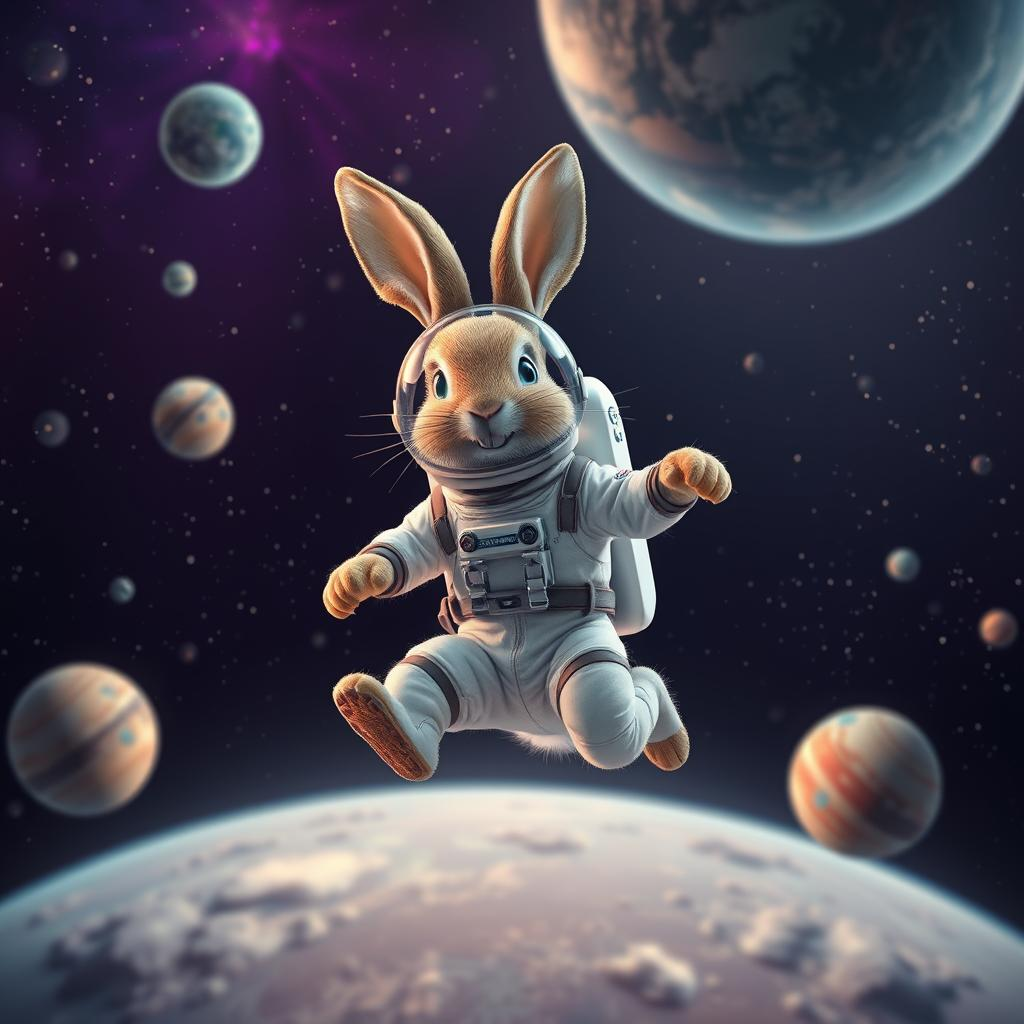

In [ ]:
from IPython.display import Image, display
display(Image(filename=result))

### 3.3 Example trying to trigger the retriever agent for the HF docs knowledge base

In [ ]:
manager_agent.run("How can I push a model to the Hub?")

======== New task ========
How can I push a model to the Hub?
=== Agent thoughts:
Thought: To provide instructions on how to push a model to the Hugging Face Hub, it would be most effective to retrieve official documentation or a guide that gives detailed steps. I'll use the `retriever` tool to find relevant information in the Hugging Face documentation or the PEFT issues section.
>>> Agent is executing the code below:
retriever(query="How to push a model to the Hugging Face Hub")
====
Code execution failed due to the following error:
ManagedAgent.__call__() missing 1 required positional argument: 'request'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/agents.py", line 1135, in step
    result = self.python_evaluator(
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 902, in evaluate_python_code
    result = evaluate_ast(node, state, static_tools, custom_tools, authorized_imports)
  

"\n1. **Prepare Your Model**: Ensure your model is trained and saved in a format compatible with the Hugging Face Transformers library. This typically involves saving the model and tokenizer using the `save_pretrained` method.\n\n2. **Install Dependencies**: Install the `huggingface_hub` library if you haven't already. You can do this using pip:\n   ```bash\n   pip install huggingface_hub\n   ```\n\n3. **Login to Hugging Face**: You need to be logged in to your Hugging Face account. Use the `huggingface-cli` to log in:\n   ```bash\n   huggingface-cli login\n   ```\n   This will prompt you to enter your Hugging Face API token, which you can find in your account settings on the Hugging Face website.\n\n4. **Create a Repository**: Create a new repository on the Hugging Face Hub using the `create_repo` command. Replace `<model_name>` with the name you want for your model:\n   ```bash\n   huggingface-cli repo create <model_name> --organization <your_organization> --private\n   ```\n   If yo

### 3.4 Example trying to trigger the retriever agent for the PEFT issues knowledge base

In [ ]:
manager_agent.run("How do you combine multiple adapters in peft?")

======== New task ========
How do you combine multiple adapters in peft?
=== Agent thoughts:
Thought: To combine multiple adapters in PEFT, I need to understand the mechanism for doing so. I will use the `retriever` tool to search for relevant information in the PEFT documentation or issues.
>>> Agent is executing the code below:
retriever(query="combine multiple adapters in peft")
====
Code execution failed due to the following error:
ManagedAgent.__call__() missing 1 required positional argument: 'request'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/agents.py", line 1135, in step
    result = self.python_evaluator(
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 902, in evaluate_python_code
    result = evaluate_ast(node, state, static_tools, custom_tools, authorized_imports)
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 782, i

'\nCombining multiple adapters in PEFT is possible but has some limitations:\n1. Only adapters of the same type (e.g., LoRA, IA3) can be loaded and inferred together.\n2. Use the `add_weighted_adapter` function to add and merge adapters.\n3. Merging adapter heads is not fully implemented and may require manual handling.\n\nTo combine multiple adapters:\n1. Ensure all adapters are of the same type.\n2. Use the `add_weighted_adapter` function to merge adapters with weighted contributions.\n3. Manually handle the merging of adapter heads if necessary.\n'

🏁 **Final Thoughts**

We have successfully built a multi-agent RAG system that integrates Web Search, Document Retrieval, and Image Generation agents, all orchestrated by a central agent manager. This architecture enables seamless task delegation, efficient processing, and the flexibility to handle a wide variety of user queries.

🔍 **Explore More**

- [Agents Cookbook](agents)
- [Advanced RAG Cookbook](advanced_rag)
- [More Cookbooks](https://huggingface.co/learn/cookbook/index)
- [Learn more about Agentic RAG](https://weaviate.io/blog/what-is-agentic-rag)
